In [1]:
import os
import sys
import re
import csv
import warnings
import pickle
import datetime
import tensorflow as tf 
import pandas as pd
import traceback
import tqdm
import time 
import json
import numpy as np 
from itertools import islice
from collections import defaultdict
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras import Input 
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout, Embedding, BatchNormalization
warnings.filterwarnings("ignore")
csv.field_size_limit(500 * 1024 * 1024)

path='/Users/wangshihang/Documents/Code/fake-news/train.csv'
word_dict = defaultdict(int)
with open(path, 'r', encoding='utf-8') as f:
    rdr = csv.reader(f, delimiter=',', quotechar='"')
    for row in islice(rdr, 1, None):
        txt = re.sub("^\s*(.-)\s*$", "%1", row[3]).replace('\n', '')
        txt = txt.split()
        for word in txt:
            word_dict[word.lower()]+=1
word_list=sorted(word_dict.items(), key=lambda d: -d[1])
word_index={'<pad>': 0, '<start>': 1, '<unknown>': 2, '<unused>': 3}
for i in range(29996):
    word_index[word_list[i][0]]=i+4

In [23]:
'''
import pandas as pd
from sklearn.utils import shuffle
df=pd.read_csv('/Users/wangshihang/Documents/Code/fake-news/train.csv')
df = shuffle(df)
df1=df[:17800]
df2=df[17800:]
df1.to_csv('/Users/wangshihang/Documents/Code/fake-news/train2.csv', index=False)
df2.to_csv('/Users/wangshihang/Documents/Code/fake-news/valid.csv', index=False)
'''

In [2]:
def one_hot_encode(raw_y, num_classes):
    index = np.array(raw_y)
    out = np.zeros((index.shape[0], num_classes))
    out[np.arange(index.shape[0]), index-1] = 1
    return out 

def load_data(path, max_seq_len, word_index, num_classes):
    raw_y = []
    raw_x = []
    with open(path, 'r', encoding='utf-8') as f:
        rdr = csv.reader(f, delimiter=',', quotechar='"')
        for row in islice(rdr, 1, None):
            raw_y.append(int(row[4]))
            txt = re.sub("^\s*(.-)\s*$", "%1", row[3]).replace('\n', '').split()
            txt_len = len(txt)
            x = np.zeros(max_seq_len, dtype = np.int32)
            if txt_len <= max_seq_len:
                for i in range(txt_len):
                    try:
                        x[i]=word_index[txt[i]]
                    except:
                        x[i]=2
            else:
                for i in range(max_seq_len):
                    try:
                        x[i] = word_index[txt[i]]
                    except:
                        x[i]=2
            raw_x.append(x)
    all_x = np.array(raw_x)
    all_y = one_hot_encode(raw_y, num_classes)
    return all_x, all_y

def batch_iter(x, y, batch_size = 32):
    data_len = len(x)
    num_batch = (data_len + batch_size - 1) // batch_size
    indices = np.random.permutation(np.arange(data_len))
    x_shuff = x[indices]
    y_shuff = y[indices]
    for i in range(num_batch):
        start_offset = i*batch_size 
        end_offset = min(start_offset + batch_size, data_len)
        yield i, num_batch, x_shuff[start_offset:end_offset], y_shuff[start_offset:end_offset]

In [25]:
class RnnAttentionLayer(layers.Layer):
    def __init__(self, attention_size, drop_rate):
        super().__init__()
        self.attention_size = attention_size
        self.dropout = Dropout(drop_rate, name = "rnn_attention_dropout")
    
    def build(self, input_shape):
        self.attention_w = self.add_weight(name = "atten_w", shape = (input_shape[-1], self.attention_size),
                                           initializer = tf.random_uniform_initializer(), dtype = "float32",
                                           trainable = True)
        self.attention_u = self.add_weight(name = "atten_u", shape = (self.attention_size,),
                                           initializer = tf.random_uniform_initializer(), dtype = "float32",
                                           trainable = True)
        self.attention_b = self.add_weight(name = "atten_b", shape = (self.attention_size,),
                                           initializer = tf.constant_initializer(0.1), dtype = "float32",
                                           trainable = True)    
        super().build(input_shape)
    
    def call(self, inputs, training):
        x = tf.tanh(tf.add(tf.tensordot(inputs, self.attention_w, axes = 1), self.attention_b))
        x = tf.tensordot(x, self.attention_u, axes = 1)
        x = tf.nn.softmax(x)
        weight_out = tf.multiply(tf.expand_dims(x, -1), inputs)
        final_out = tf.reduce_sum(weight_out, axis = 1) 
        drop_out = self.dropout(final_out, training = training)
        return drop_out

class RnnLayer(layers.Layer):
    def __init__(self, rnn_size, drop_rate):
        super().__init__()
        fwd_lstm = LSTM(rnn_size, return_sequences = True, go_backwards= False, dropout = drop_rate,
                        name = "fwd_lstm")
        bwd_lstm = LSTM(rnn_size, return_sequences = True, go_backwards = True, dropout = drop_rate,
                        name = "bwd_lstm")
        self.bilstm = Bidirectional(merge_mode = "concat", layer = fwd_lstm, backward_layer = bwd_lstm,
                                    name = "bilstm")
    
    def call(self, inputs, training):
        outputs = self.bilstm(inputs, training = training)
        return outputs

class Model(tf.keras.Model):
    def __init__(self, num_classes, drop_rate, vocab_size, embedding_size, rnn_size, attention_size):
        super().__init__()
        embedding_weight = self.get_embedding_weight(GLoVe_path, word_index)
        self.embedding_layer = Embedding(vocab_size, embedding_size, weights=[embedding_weight],
                                         name = "embeding_0")
        self.rnn_layer = RnnLayer(rnn_size, drop_rate)
        self.attention_layer = RnnAttentionLayer(attention_size, drop_rate)
        self.dense_layer = Dense(num_classes, activation = "softmax", 
                                 kernel_regularizer=keras.regularizers.l2(0.001), name = "dense_1")

    def call(self, input_x, training):
        x = self.embedding_layer(input_x)
        x = self.rnn_layer(x, training = training)
        x = self.attention_layer(x, training = training)
        x = self.dense_layer(x)
        return x
    
    def get_embedding_weight(self, weight_path, word_index):
        embedding_weight = np.random.uniform(-0.05, 0.05, size=[30000, 100])
        cnt = 0
        with open(weight_path, 'r') as f:
            for line in f:
                values = line.split()
                word = values[0].lower()
                if word in word_index.keys() and word_index[word]< 30000:
                    weight = np.asarray(values[1:], dtype='float32')
                    embedding_weight[word_index[word]] = weight
                    cnt += 1
        print('word num: {}, matched num: {}'.format(len(word_index), cnt))
        return embedding_weight

In [27]:
def train(xy_train, xy_val, num_classes, vocab_size, epoches, batch_size):
    best_acc = 0
    uniq_cfg_name = datetime.datetime.now().strftime("%Y")
    checkpoint_prefix = os.path.join(os.getcwd(), "checkpoints2")
    if not os.path.exists(checkpoint_prefix):
        print("create model dir: %s" % checkpoint_prefix)
        os.mkdir(checkpoint_prefix)

    checkpoint_path = os.path.join(checkpoint_prefix, uniq_cfg_name)
    model = Model(num_classes, drop_rate = 0.05, vocab_size = vocab_size, embedding_size = 100,
                  rnn_size = 128, attention_size = 128)
    if os.path.exists(checkpoint_path):
        model.load_weights(checkpoint_path)
        print("load weight from: %s" % checkpoint_path)
    
    optimizer = tf.keras.optimizers.Adam(0.01)
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    
    loss_metric = tf.keras.metrics.Mean(name='train_loss')
    accuracy_metric = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')
    
    @tf.function 
    def train_step(input_x, input_y, training = True):
        if training:
            with tf.GradientTape() as tape:
                raw_prob = model(input_x, training)
                pred_loss = loss_fn(input_y, raw_prob)
            gradients = tape.gradient(pred_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        else:
            raw_prob = model(input_x, training)
            pred_loss = loss_fn(input_y, raw_prob)
        # Update the metrics
        loss_metric.update_state(pred_loss)
        accuracy_metric.update_state(input_y, raw_prob)
        return raw_prob 

    for i in range(epoches):
        t0 = time.time()
        batch_train = batch_iter(xy_train[0], xy_train[1], batch_size = batch_size)
        loss_metric.reset_states()
        accuracy_metric.reset_states()

        for batch_no, batch_tot, data_x, data_y in batch_train:
            predict_prob = train_step(data_x, data_y, True)  
      
        print("[train ep %d] [%s]: %0.3f  [%s]: %0.3f" %  (i, "loss", loss_metric.result() ,
                                                           "acc", accuracy_metric.result()))

        model.save_weights(checkpoint_path, overwrite=True)
        
        loss_metric.reset_states()
        accuracy_metric.reset_states()
        batch_test = batch_iter(xy_val[0], xy_val[1], batch_size = batch_size)
        for _, _, data_x, data_y in batch_test:
            train_step(data_x, data_y, False)
        print("[***** ep %d] [%s]: %0.3f  [%s]: %0.3f" %  (i, "loss", loss_metric.result() ,
                                                           "acc", accuracy_metric.result()))
        if accuracy_metric.result()>best_acc:
            model.save('./model2/fake_news_cls')
            best_acc=accuracy_metric.result()

In [28]:
if __name__ == "__main__":
    max_seq_len = 256
    num_classes = 2
    vocab_size = 30000
    train_path='/Users/wangshihang/Documents/Code/fake-news/train2.csv'
    test_path='/Users/wangshihang/Documents/Code/fake-news/valid.csv'
    GLoVe_path = '/Users/wangshihang/Documents/Code/Glove/glove.twitter.27B.100d.txt'

    ### gen samples ###
    train_x, train_y = load_data(train_path, max_seq_len, word_index, num_classes)
    test_x, test_y = load_data(test_path, max_seq_len, word_index, num_classes)
    key, freq = np.unique(np.argmax(train_y, axis = 1), return_counts = True)
    train([train_x, train_y], [test_x, test_y], num_classes, vocab_size, epoches = 3, batch_size = 32)

word num: 30000, matched num: 18702
[train ep 0] [loss]: 0.171  [acc]: 0.927
[***** ep 0] [loss]: 0.081  [acc]: 0.966


INFO:tensorflow:Assets written to: ./model2/fake_news_cls/assets


INFO:tensorflow:Assets written to: ./model2/fake_news_cls/assets


[train ep 1] [loss]: 0.036  [acc]: 0.988
[***** ep 1] [loss]: 0.087  [acc]: 0.970


INFO:tensorflow:Assets written to: ./model2/fake_news_cls/assets


INFO:tensorflow:Assets written to: ./model2/fake_news_cls/assets


[train ep 2] [loss]: 0.010  [acc]: 0.997
[***** ep 2] [loss]: 0.102  [acc]: 0.970


In [8]:
max_seq_len = 256
num_classes = 2
test_path='/Users/wangshihang/Documents/Code/fake-news/valid.csv'
test_x, test_y = load_data(test_path, max_seq_len, word_index, num_classes)

model = tf.keras.models.load_model("./model2/fake_news_cls")
preds = []
for i in range(94):
    input_x=test_x[i*32:(i+1)*32]
    raw_prob = model(input_x, training=False).numpy()
    label = np.argmax(raw_prob,axis=1)
    preds.extend(label)

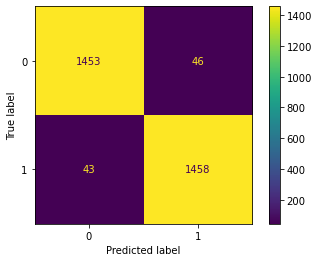

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
labels=np.argmax(test_y, axis=1)
cm=confusion_matrix(preds, labels)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [10]:
from sklearn import metrics
print('acc: ', metrics.accuracy_score(labels, preds))
print('pre: ', metrics.precision_score(labels, preds, average='macro'))
print('rcl: ', metrics.recall_score(labels, preds, average='macro'))
print('f1: ', metrics.f1_score(labels, preds, average='macro'))

acc:  0.9703333333333334
pre:  0.9703326534811794
rcl:  0.9703357890544999
f1:  0.970333250925697
